# **On the Hunt for Pulsar Stars**

# Introduction

**Pulsar stars** are neutron stars that produce radio emission, which when continuously and rapidly rotated, produce a detectable periodic radio emission. In astronomical research, possible pulsar stars can be identified as **‘candidates.’** Candidates are characterized by the average value of different patterns produced by their rotations. Nearly 2,000 pulsars have been discovered, however there are still many more unidentified in our galaxy (Keith et al., 2010). 


<img src="https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif" width="480" />

*Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif*


*A High Time Resolution Universe Survey was done to collect data on pulsar star candidates using a radio telescope. 
Of 17,898 collected candidates:
* 1,639 were pulsar stars
* 16259 were RFI/noise (false candidates)

These stars were characterized by **8 variables** from the integrated pulse profile and *DM-SNR curve (Dispersion Measure v. Signal-to-Noise Ratio curve)*.


The question we aim to address is:
* *Will a presented pulsar star candidate be a pulsar star?*



The data set we are working with is characterized by the following:
* **Data format**: CSV.
* **Multivariate** data set.
* Candidates in separate rows.
* Candidates described by **8 continuous variables**:
    - Variables 1-4: simple statistics from **pulse (folded) profile**
    - Variables 6-8: simple statistics from **DM-SNR curve**
    - Variable 9: **class variable** [0 (negative class, non-pulars) or 1 (positive class, pulsars)]


In [20]:
library(tidyverse)
library(cowplot)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
set.seed(8) 

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Preliminary exploratory data analysis:

- Data set read from web into R using `read_csv`.
- Column names added for each variable.

In [2]:
star_data <- read_csv("HTRU_2.csv", col_names=FALSE, show_col_types = FALSE) |>
    mutate(X9 = as_factor(X9))

colnames(star_data) <- c("integrated_profile_mean", "integrated_profile_st_dev", 
                         "integrated_profile_excess_kurtosis","integrated_profile_skewness",
                         "dm_snr_curve_mean","dm_snr_curve_st_dev",
                         "dm_snr_curve_excess_kurtosis","dm_snr_curve_skewness",
                         "is_pulsar_star")

sample_n(star_data, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
114.0703,44.03092,0.28220333,0.4744331,5.722408,28.83081,5.446753,30.54567,0
110.6641,48.61556,0.21281297,0.3979286,1.119565,10.75650,15.186406,294.92017,0
123.8984,56.99587,0.14767151,-0.4008838,4.507525,24.41936,7.008171,54.56412,0
123.1250,57.95257,-0.02614993,-0.5889716,4.267559,22.16702,6.157607,43.93578,0
124.4688,47.52613,0.01427172,0.6629192,3.272575,22.30450,7.995575,69.36484,0


↑ This table shows the 8 characteristics of a pulsar star. Only the first 5 rows are displayed.

* Data was split into testing data and training data, 75% went to `star_training_data`, 25% to `star_testing_data`.

The first 5 rows are displayed:

In [3]:
star_split <- initial_split(star_data, prop = 0.75, strata = is_pulsar_star)  

star_training_data <- training(star_split)   
star_testing_data <- testing(star_split)

sample_n(star_training_data, 5)
sample_n(star_testing_data, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37.32812,43.89781,3.21738447,10.5046769,107.1020067,50.97228,1.015688,0.4953032,1
136.80469,49.10210,0.14625492,-0.2538245,4.0777592,22.22434,6.935962,55.1423140,0
126.69531,48.93036,0.01131605,-0.1529538,0.5384615,10.22764,21.014750,464.6081237,0
133.61719,60.14528,-0.10607725,-0.6559634,2.2249164,14.84075,9.744411,119.2188302,0
119.96875,53.72324,0.27224503,-0.4774965,30.0827759,66.01191,1.840602,1.6020830,0


integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
124.18750,37.85782,0.2526057,1.07692640,2.576923,21.61591,8.867911,80.15800,0
130.48438,51.21645,-0.1640841,-0.02523602,2.231605,13.24925,10.182786,142.57097,0
117.06250,46.59898,0.3441224,0.46497399,4.186455,20.11384,6.182872,46.29682,0
99.20312,45.92306,0.1434917,0.15674709,2.061037,13.49571,10.507315,143.67341,0
85.85938,35.06261,0.8376860,3.15882979,1.857860,14.12113,10.580364,136.88359,0



↑ The top table shows the first 5 rows in the training dataset. The bottom table shows the first 5 rows in the testing dataset.

In [4]:
star_num_table <- star_training_data |>
    group_by(is_pulsar_star) |>
    summarize(num_stars = n())
star_num_table

is_pulsar_star,num_stars
<fct>,<int>
0,12202
1,1221


↑ Displays number of pulsar(1) and non-pulsar(0) stars in training set, proportion similar to original data.

In [5]:
star_means_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, mean))
star_means_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,116.50534,47.30364,0.2103593,0.3820545,8.617337,23.18821,8.830369,112.11089
1,56.18818,38.69459,3.1520811,15.6685190,50.501365,56.50310,2.705860,16.98838


↑ Calculated mean of every column in training set, grouped by non-pulsar and pulsar.

In [6]:
star_max_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, max))
star_max_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,192.6172,91.20647,4.529319,20.69544,223.3921,110.6422,34.53984,1191.001
1,139.2578,83.79691,8.069522,68.10162,184.5259,109.6553,19.62280,479.671


↑ Identified the maximum of every column in the training set, grouped by non-pulsar and pulsar.

In [7]:
star_var_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, var))
star_var_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,303.2781,37.81281,0.1088353,1.013959,567.5257,265.4654,17.305558,10697.51
1,914.0622,63.22708,3.5298943,196.416866,2060.7104,383.1623,9.035148,1887.03


↑ Calculated the variance of every column in the training set, grouped by non-pulsar and pulsar.

- Graphing various potential predictor variables as described by titles.
- Mean, standard deviation, excess kurtosis, skewness of integrated profile and DM-SNR curve plotted against each other.

Mean of Integrated Profile verses the mean of DM-SNR Curve plotted in scatterplot:

In [8]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_1<- ggplot(star_training_data, aes(x = integrated_profile_mean, y = dm_snr_curve_mean, color = is_pulsar_star)) +
    geom_point(alpha=0.5) +
    labs(x = "Mean Value from Integrated Profile",
         y = "Mean Value from DM-SNR Curve",
         color = "Pulsar Star?") +
    ggtitle("Pulsar Candidate DM-SNR  vs Integrated Profile Mean") +
    theme(text = element_text(size = 15))

Skewness of Integrated Profile verses skewness of DM-SNR Curve plotted in scatterplot:

In [9]:
plot_2 <- ggplot(star_training_data, aes(x = integrated_profile_skewness, y = dm_snr_curve_skewness,
                         color = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Skewness",
         y = "DM-SNR curve Skewness",
         color = "Pulsar Star?") +
    ggtitle("Integrated Profile Skewness vs DM-SNR Curve Skewness") +
    theme(text = element_text(size = 15))

Standard deviation of Integrated Profile verses Standard Deviation of SM-SNR Curve plotted in scatterplot:

In [10]:
plot_3 <- ggplot(star_training_data, aes(x = integrated_profile_st_dev, y = dm_snr_curve_st_dev,
                         color = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Standard Deviation",
         y = "DM-SNR curve Standard Deviation",
         color = "Pulsar Star?") +
    ggtitle("DM-SNR curve Standard Deviation vs Integrated Profile Standard Deviation") +
    theme(text = element_text(size = 15))

Excess kurtosis of Integrated Profile verses excess kurtosis of DM-SNR curve plotted in scatterplot:

In [11]:
plot_4 <- ggplot(star_training_data, aes(x = integrated_profile_excess_kurtosis, y = dm_snr_curve_excess_kurtosis,
                         color = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Excess Kurtosis",
         y = "DM-SNR curve Excess Kurtosis",
         color = "Pulsar Star?") +
    ggtitle("DM-SNR curve Excess Kurtosis vs Integrated Profile Excess Kurtosis") +
    theme(text = element_text(size = 15))

Putting plots together so they can be compared easily.

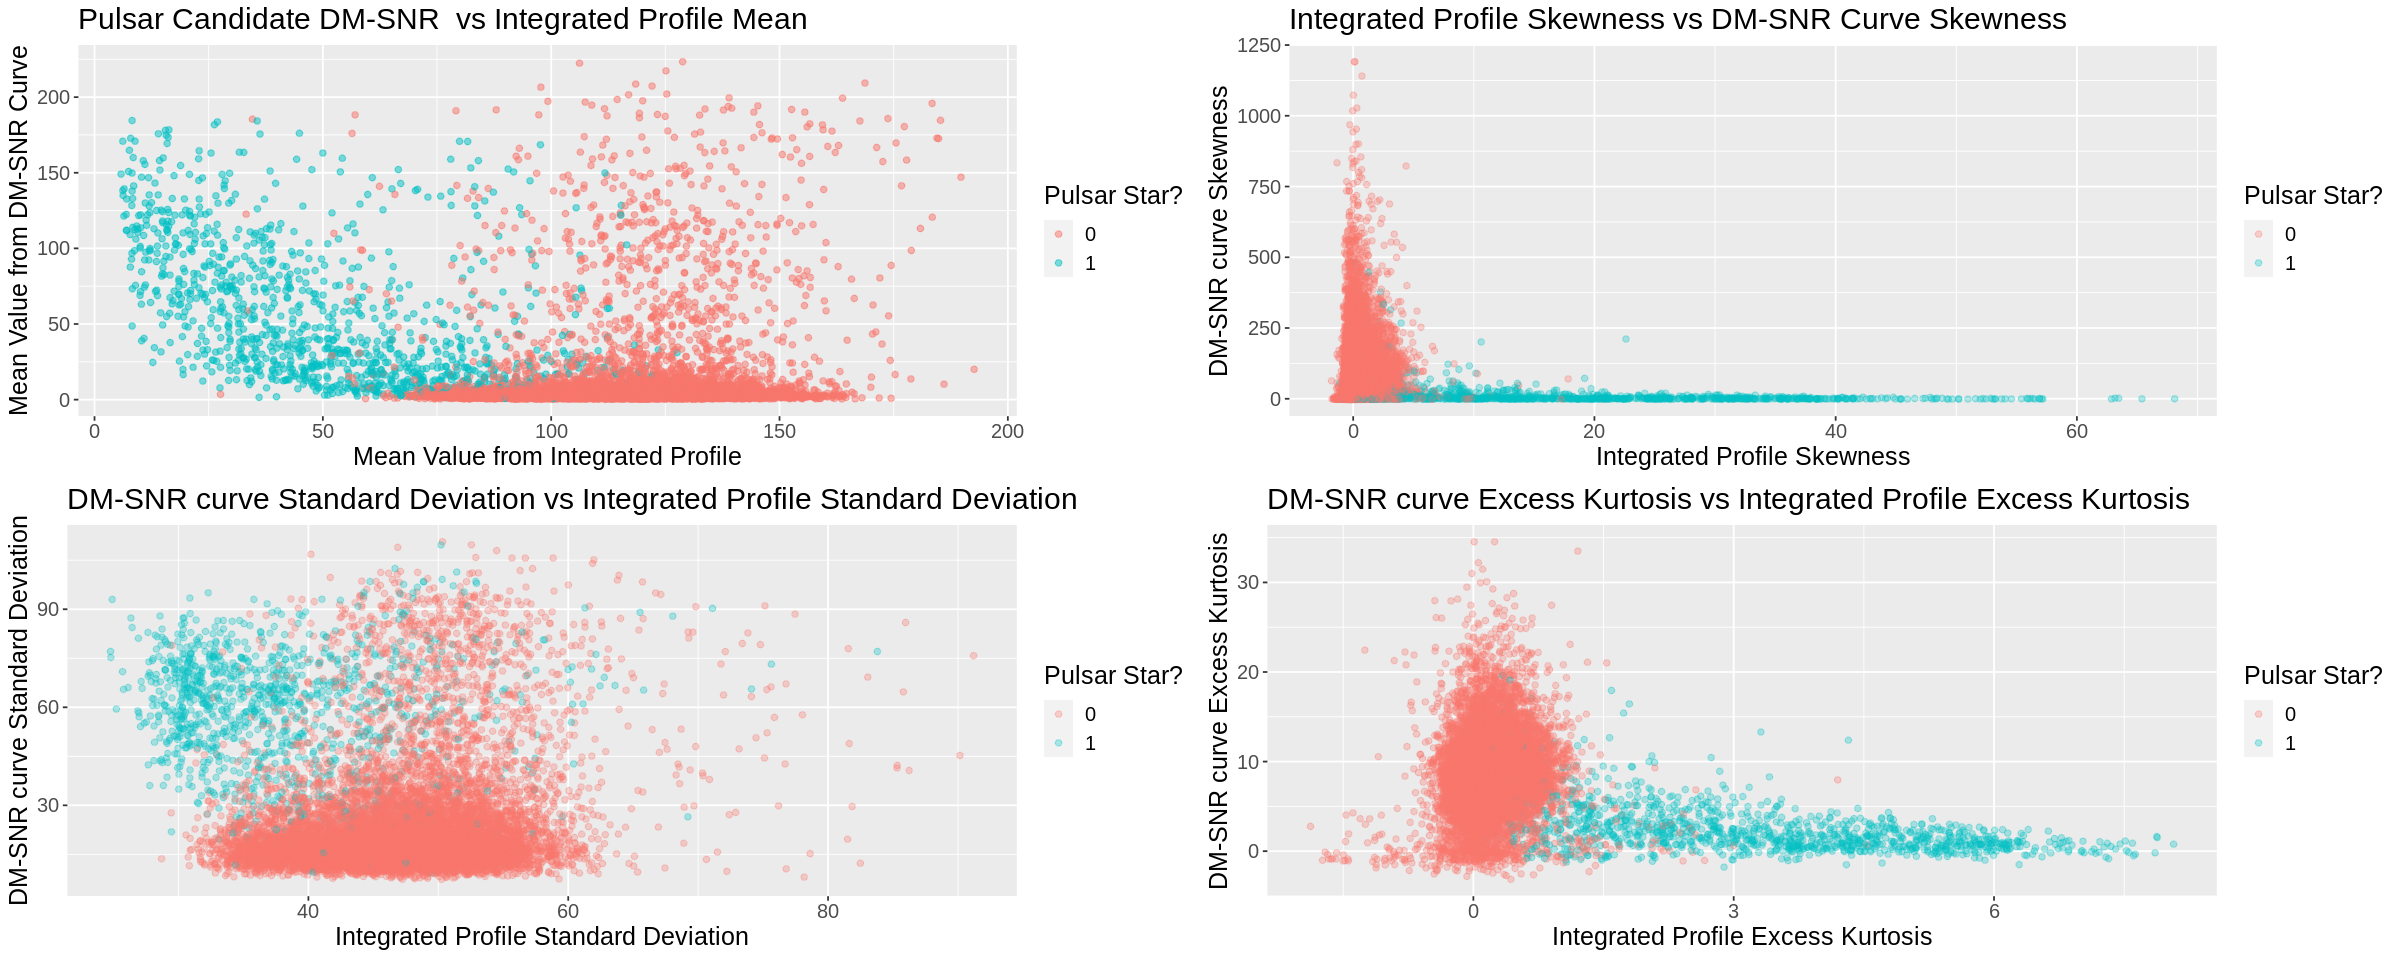

In [12]:
plot_grid(plot_1,plot_2,plot_3,plot_4)

As can be seen from above, pulsar stars seem to have:
- smaller integrated profile means, as seen from the Pulsar Candidate DM-SNR vs. Integrated Profile Mean graph
- higher integrated profile skewness and lower DM-SNR skewness values, as seen from the Integrated Profile Skewness vs. DM-SNR Skewness
- higher DM-SNR standard deviations and lower integrated profile standard deviations, as seen from the DM-SNR Curve Standard Deviation vs. Integrated Profile Standard Deviation graph
- higher integrated profile excess kurtosis values, as seen from the DM-SNR Curve Excess Kurtosis vs. Integrated Profile Excess Kurtosis graph
compared to their false counterparts

- Standardized data using `mutate` and `scale`.

In [13]:
star_data_standardized <- star_training_data |>
    mutate(integrated_profile_mean = scale(integrated_profile_mean, center = TRUE),
           integrated_profile_st_dev = scale(integrated_profile_st_dev, center = TRUE),
           integrated_profile_excess_kurtosis = scale(integrated_profile_excess_kurtosis, center = TRUE),
           integrated_profile_skewness = scale(integrated_profile_skewness, center = TRUE),
           dm_snr_curve_mean = scale(dm_snr_curve_mean, center = TRUE),
           dm_snr_curve_st_dev = scale (dm_snr_curve_st_dev, center = TRUE),
           dm_snr_curve_excess_kurtosis = scale(dm_snr_curve_excess_kurtosis, center = TRUE),
           dm_snr_curve_skewness = scale(dm_snr_curve_skewness, center = TRUE))

sample_n(star_data_standardized, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.73252505,-0.1300219,-0.68355585,-0.22365078,0.3730009,1.7559941,-1.34710814,-0.9681864,0
0.88019541,-0.1019875,-0.45826891,-0.23393579,-0.3624643,-0.5297555,0.49081428,0.1924498,0
-0.91359042,-1.1071840,0.12638758,-0.01184725,-0.3357948,-0.3845127,-0.00653817,-0.2703799,0
0.08261928,0.2152671,-0.04679582,-0.28787811,-0.3632681,-0.7169309,0.66843903,0.6609168,0
-1.03800256,-1.2665864,0.33890270,0.03204081,-0.3284169,-0.3138286,-0.03218724,-0.3141215,0


Calculated means for each class with standardized data this time to see what changes using `group_by` and `summarize`:

In [14]:
star_means_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, mean))
star_means_table_standardized

star_max_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, max))
star_max_table_standardized

star_means_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, var))
star_means_table_standardized

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2136271,0.1151515,-0.2511261,-0.2252767,-0.1308114,-0.1579882,0.125663,0.08386763
1,-2.1348715,-1.1507610,2.5096156,2.2512913,1.3072572,1.5788464,-1.255807,-0.83812683


is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3.177105,6.570820,3.802124,3.065706,7.243381,4.401328,5.924801,10.541230
1,1.099514,5.481284,7.124527,10.746005,5.908928,4.349879,2.560050,3.646519


is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0.4597693,0.8175912,0.09585578,0.0266138,0.6690335,0.7215193,0.8804934,1.0050150
1,1.3857172,1.3671004,3.10892362,5.1554335,2.4292896,1.0414126,0.4597014,0.1772837


Now, it is easier to compare the data since it is standardized.

# Methods

We chose a classification model. We will be using all the variables/columns because in Robert James Lyon's thesis, the features of the integrated profile and the DM-SNR curve are all crucial in determining pulsar stars from candidates (Lyon, 2016). We will conduct our data analysis using a standardized training and testing data set, perform cross validation, and pick the best K value by creating a Accuracy Estimate vs. Neighbors graph. We will visualize our data using a scatter plot with different colors to allow us to determine training data's accuracy in predicting pulsar candidates from the test data.

In [24]:
star_recipe <- recipe(is_pulsar_star ~., data = star_training_data)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())|>
    step_upsample(is_pulsar_star,over_ratio = 1, skip=FALSE)

upsampled_stars <- star_recipe|>
    prep()|>
    bake(star_training_data)

upsampled_stars |>
  group_by(is_pulsar_star) |>
  summarize(n = n())

is_pulsar_star,n
<fct>,<int>
0,12202
1,12202


# Discussion

**Possible Significance of Findings**:

These findings could aid in exploration of the interstellar medium. Only 2,000 pulsar stars have been discovered, therefore any additional discoveries will be of significant impact in the field of astronomy (Skelly, 2017).


**Future questions this could lead to:**

    - How old are the pulsar stars found?
    - How can precise measurements of the pulsar stars sizes and masses be determined?
    - Are there areas of the galaxy where more pular stars are found?


### Sources

Keith, M. J., Jameson, A., van Straten, W., Bailes, M., Johnston, S., Kramer, M., Possenti, A., Bates, S. D., Bhat, N. D. R., Burgay, M., Burke-Spolaor, S., D'Amico, N., Levin, L., McMahon, P. L., Milia, S., Stappers, B. W. (2010). The High Time Resolution Universe Pulsar Survey – I. System configuration and initial discoveries. _Monthly Notices of the Royal Astronomical Society, 409(2)_, 619–627. https://doi.org/10.1111/j.1365-2966.2010.17325.x

Lyon, R. J.(2016). Why are Pulsars Hard to Find [Doctoral Dissertation, University of Manchester]. https://www.escholar.manchester.ac.uk/api/datastream?publicationPid=uk-ac-man-scw:305203&datastreamId=FULL-TEXT.PDF

Skelly, C. (2017). NASA Continues to Study Pulsars, 50 Years After Their Chance Discovery. _NASA_. https://www.nasa.gov/feature/goddard/2017/nasa-continues-to-study-pulsars-50-years-after-their-chance-discovery